In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.distributions import Normal as norm
from termcolor import colored
from sklearn.decomposition import PCA
from scipy import linalg as LA
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import multinomial
from scipy.stats import logistic
from Main_functions import *
import random
from numpy import genfromtxt

### Given the eigenvalues of ground truth $M_t$, we randomly generate it.

In [2]:
model_type = "Logistic"
noise_type = 'Logistic'

In [3]:
d = 10
rank = 5
seed = 2023

In [4]:
np.random.seed(seed)
non_zero_eigens_of_M_star = np.round(np.random.uniform(low=0.0, high=1.0, size= rank), 2)

In [5]:
non_zero_eigens_of_M_star

array([0.32, 0.89, 0.59, 0.13, 0.14])

In [6]:
diag = np.zeros(d)
diag[:rank] = non_zero_eigens_of_M_star
diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [7]:
data_model = DG(diag, seed = 22)

Ground truth M_t and B_t are generated (M_t = B_t @ B_t.T)
To access to M_t and B_t, use .M_t and .B_t


In [8]:
data_model.M_diag

array([0.32, 0.89, 0.59, 0.13, 0.14, 0.  , 0.  , 0.  , 0.  , 0.  ])

In [9]:
data_model.M_t.shape, data_model.B_t.shape

((10, 10), (10, 10))

### Given the eigenvalue of covariance matrix Cov, we randomly generate it.

In [10]:
np.random.seed(2024)
diag_cov = np.round(np.random.uniform(low=0.0, high=1.0, size= d), 2)

In [11]:
diag_cov

array([0.59, 0.7 , 0.19, 0.04, 0.21, 0.11, 0.73, 0.68, 0.47, 0.45])

In [12]:
diag_cov.sum()

4.17

In [13]:
Sigma, U_sigma = random_covariance(diag_cov, seed = 21)

In [14]:
f = multivariate_normal(mean = np.zeros(d), cov = Sigma)

In [15]:
snm = 2 * np.trace(data_model.M_t @ Sigma)
print("squared norm mean = {}".format(snm))

squared norm mean = 1.6983720913430767


In [16]:
N = 20000
s = 0.2

In [17]:
tau = [0.15]
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                          noise_type = 'Logistic', noise_par = s)

noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i, (D_no_noisy==i).sum()))
    
print((D_no_noisy== 0).sum()/N)

the amount of noise: 0.0589
number of pairs with 0 as their labels is 308
number of pairs with 1 as their labels is 19692
0.0154


In [18]:
tau = [6.2]
X, Y, D_noisy, D_no_noisy = data_model.generate(f, N, tau = np.array(tau), 
                                          noise_type = 'Logistic', noise_par = s)

noise_amount = (D_noisy != D_no_noisy).mean()
print('the amount of noise: {}'.format(noise_amount))

for i in range(len(tau)+1):
    print('number of pairs with {} as their labels is {}'.format(i, (D_no_noisy==i).sum()))
    
print((D_no_noisy== 0).sum()/N)

the amount of noise: 0.0034
number of pairs with 0 as their labels is 19656
number of pairs with 1 as their labels is 344
0.9828


In [19]:
tau_list = np.linspace(0.1, 6.1, 30)

In [20]:
model_history = []
J = []
N = 60000
k = d = 10
n_labels = 2
s = 0.2

close_portion = []
close_portion_noisy = []

Train_accuracy_noisey = []
Train_accuracy_far_points_noisy = []
Train_accuracy_close_points_noisey = []


Test_accuracy_noisey = []
Test_accuracy_far_points_noisy = []
Test_accuracy_close_points_noisey = []



Train_accuracy_no_noisey = []
Train_accuracy_far_points_no_noisy = []
Train_accuracy_close_points_no_noisey = []


Test_accuracy_no_noisey = []
Test_accuracy_far_points_no_noisy = []
Test_accuracy_close_points_no_noisey = []

In [21]:
# for tau in tau_list:
        
#     X, Y, D_noisy, D_no_noisy = data_model.generate(f, 
#                                                     N = N, 
#                                                     tau = np.array([tau]), 
#                                                     noise_type = noise_type, 
#                                                     noise_par = s)
    
#     print('for tau = {}, {}% of points are labeled close in D_no_noisy'.format(tau, 100*(D_no_noisy== 0).sum()/N))
#     print('for tau = {}, {}% of points are labeled close in D_noisy'.format(tau, 100*(D_noisy== 0).sum()/N))

In [22]:
for tau in tau_list:
        
    X, Y, D_noisy, D_no_noisy = data_model.generate(f, 
                                                    N = N, 
                                                    tau = np.array([tau]), 
                                                    noise_type = noise_type, 
                                                    noise_par = s)
    
    print('for tau = {}, {}% of points are labeled close in D_no_noisy'.format(tau, 100*(D_no_noisy== 0).sum()/N))
    print('for tau = {}, {}% of points are labeled close in D_noisy'.format(tau, 100*(D_noisy== 0).sum()/N))
        
    X = torch.tensor(X, dtype = torch.float64)
    Y = torch.tensor(Y, dtype = torch.float64)
    D_noisy = torch.tensor(D_noisy, dtype = torch.torch.int64)
    D_no_noisy = torch.tensor(D_no_noisy, dtype = torch.torch.int64)
        
    
    J.append(tau)
    close_portion.append(100*(D_no_noisy == 0).sum()/N)
    close_portion_noisy.append(100*(D_noisy == 0).sum()/N)
    
    X, Y, D, X_T, Y_T, D_T, D_no_noise_T, X_test, Y_test, D_test, D_no_noise_test = train_test_split(X, 
                                                                                                     Y, 
                                                                                                 D_noisy, 
                                                                                                 D_no_noisy, 
                                                                                                 n_train = 20000)
    
    
    
    
    model = ML(d, k, n_labels, 
               X_T, Y_T, 
               D_T, D_no_noise_T, 
               X_test, Y_test, 
               D_test, D_no_noise_test, 
               Type = 'Logistic') 
    
    model.train(learning_rate = 5e-1, 
                n_iters = 30000, 
                decay = .95, 
                show_log = False,
                f = f, 
                B_star = data_model.B_t, 
                tau_star = data_model.tau_t, 
                N = 1000)
    
    model_history.append(model)
    
    train_accuracy_noisey =  model_history[-1].accuracy(model_history[-1].X_T, 
                                                        model_history[-1].Y_T, 
                                                        model_history[-1].D_T)
    Train_accuracy_noisey.append(train_accuracy_noisey)
    
    
    print('train_accuracy (noisey) = {}'.format(train_accuracy_noisey)) 
    
    
    
    I_far = (D_T == 1)
    X_T_far = X_T[I_far]
    Y_T_far = Y_T[I_far]
    D_T_far = D_T[I_far]
    
    train_accuracy_far_points_noisy = model_history[-1].accuracy(X_T_far,
                                                                 Y_T_far, 
                                                                 D_T_far)
    Train_accuracy_far_points_noisy.append(train_accuracy_far_points_noisy)
    
    
    print('train_accuracy_far_points (noisey)  = {}'.format(train_accuracy_far_points_noisy))
    
    
    I_close = (D_T == 0)
    X_T_close = X_T[I_close]
    Y_T_close = Y_T[I_close]
    D_T_close = D_T[I_close]    
    
    train_accuracy_close_points_noisey = model_history[-1].accuracy(X_T_close,
                                                                    Y_T_close, 
                                                                    D_T_close)
    
    Train_accuracy_close_points_noisey.append(train_accuracy_close_points_noisey)
    
    print('train_accuracy_close_points (noisey)  = {}'.format(train_accuracy_close_points_noisey))
    print('\n')
#----------------------------------------------------------------------------------------------------     

    test_accuracy_noisey = model_history[-1].accuracy(model_history[-1].X_test, 
                                                      model_history[-1].Y_test, 
                                                      model_history[-1].D_test)
    
    Test_accuracy_noisey.append(test_accuracy_noisey)
    
    print('test_accuracy (noisey) = {}'.format(test_accuracy_noisey))
    
    
    
    I_far = (D_test == 1)
    X_test_far = X_test[I_far]
    Y_test_far = Y_test[I_far]
    D_test_far = D_test[I_far] 
    
    
    test_accuracy_far_points_noisy = model_history[-1].accuracy(X_test_far,
                                                                Y_test_far, 
                                                                D_test_far)
    
    Test_accuracy_far_points_noisy.append(test_accuracy_far_points_noisy)

    print('test_accuracy_far_points (noisey) = {}'.format(test_accuracy_far_points_noisy)) 
    
    
    
    I_close = (D_test == 0)
    X_test_close = X_test[I_close]
    Y_test_close = Y_test[I_close]
    D_test_close = D_test[I_close]   
    
    test_accuracy_close_points_noisey = model_history[-1].accuracy(X_test_close, 
                                                                   Y_test_close,  
                                                                   D_test_close)
    
    Test_accuracy_close_points_noisey.append(test_accuracy_close_points_noisey)
    
    print('test_accuracy_close_points (noisey) = {}'.format(test_accuracy_close_points_noisey))  
    
    print('\n')
    
#----------------------------------------------------------------------------------------------------  

    train_accuracy_no_noisey = model_history[-1].accuracy(model_history[-1].X_T,
                                                          model_history[-1].Y_T, 
                                                          model_history[-1].D_no_noise_T)
    Train_accuracy_no_noisey.append(train_accuracy_no_noisey)
    print('train_accuracy (no noise) = {}'.format(train_accuracy_no_noisey))
    
    
    
    I_far = (D_no_noise_T == 1)
    X_T_far = X_T[I_far]
    Y_T_far = Y_T[I_far]
    D_no_noise_T_far = D_no_noise_T[I_far]
    
    
    train_accuracy_far_points_no_noisy = model_history[-1].accuracy(X_T_far, 
                                                                    Y_T_far, 
                                                                    D_no_noise_T_far)
    Train_accuracy_far_points_no_noisy.append(train_accuracy_far_points_no_noisy)
    print('train_accuracy_far_points (no noise) = {}'.format(train_accuracy_far_points_no_noisy))
    
    
    I_close = (D_no_noise_T == 0)
    X_T_close = X_T[I_close]
    Y_T_close = Y_T[I_close]
    D_no_noise_T_close = D_no_noise_T[I_close] 
    
    train_accuracy_close_points_no_noisey = model_history[-1].accuracy(X_T_close,
                                                                       Y_T_close, 
                                                                       D_no_noise_T_close)
    Train_accuracy_close_points_no_noisey.append(train_accuracy_close_points_no_noisey)
    print('train_accuracy_close_points (no noise) = {}'.format(train_accuracy_close_points_no_noisey))  
    print('\n')
    
#----------------------------------------------------------------------------------------------------      
    
    
    test_accuracy_no_noisey = model_history[-1].accuracy(model_history[-1].X_test, 
                                                         model_history[-1].Y_test, 
                                                         model_history[-1].D_no_noise_test)
    Test_accuracy_no_noisey.append(test_accuracy_no_noisey)
    print('test_accuracy (no noise) = {}'.format(test_accuracy_no_noisey))
    
    
    I_far = (D_no_noise_test == 1)
    X_test_far = X_test[I_far]
    Y_test_far = Y_test[I_far]
    D_no_noise_test_far = D_no_noise_test[I_far]
    
    test_accuracy_far_points_no_noisy = model_history[-1].accuracy(X_test_far, 
                                                                   Y_test_far, 
                                                                   D_no_noise_test_far)
    Test_accuracy_far_points_no_noisy.append(test_accuracy_far_points_no_noisy)
    print('test_accuracy_far_points (no noise) = {}'.format(test_accuracy_far_points_no_noisy))
    
    
    I_close = (D_no_noise_test == 0)
    X_test_close = X_test[I_close]
    Y_test_close = Y_test[I_close]
    D_no_noise_test_close = D_no_noise_test[I_close]    
    
    test_accuracy_close_points_no_noisey = model_history[-1].accuracy(X_test_close, 
                                                                      Y_test_close, 
                                                                      D_no_noise_test_close)
    Test_accuracy_close_points_no_noisey.append(test_accuracy_close_points_no_noisey)
    print('test_accuracy_close_points (no noise) = {}'.format(test_accuracy_close_points_no_noisey))
    
      
#----------------------------------------------------------------------------------------------------      
    print('\n\n\n')
      

for tau = 0.1, 0.56% of points are labeled close in D_no_noisy
for tau = 0.1, 5.026666666666666% of points are labeled close in D_noisy
train_accuracy (noisey) = 0.9502
train_accuracy_far_points (noisey)  = 0.9965780468544354
train_accuracy_close_points (noisey)  = 0.0736318407960199


test_accuracy (noisey) = 0.950725
test_accuracy_far_points (noisey) = 0.9970254547368975
test_accuracy_close_points (noisey) = 0.07608155146693188


train_accuracy (no noise) = 0.99685
train_accuracy_far_points (no noise) = 0.9979877251232518
train_accuracy_close_points (no noise) = 0.8114754098360656


test_accuracy (no noise) = 0.9964
test_accuracy_far_points (no noise) = 0.9975368219976877
test_accuracy_close_points (no noise) = 0.7850467289719626




for tau = 0.30689655172413793, 6.193333333333333% of points are labeled close in D_no_noisy
for tau = 0.30689655172413793, 10.055% of points are labeled close in D_noisy
train_accuracy (noisey) = 0.9145
train_accuracy_far_points (noisey)  = 0.97502358883

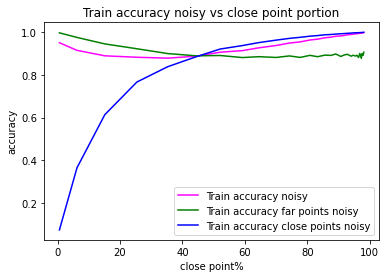

In [23]:
plt.plot(close_portion, 
         Train_accuracy_noisey, 
         label = 'Train accuracy noisy', 
         color = 'magenta')

plt.plot(close_portion, 
         Train_accuracy_far_points_noisy, 
         label = 'Train accuracy far points noisy', 
         color = 'green')

plt.plot(close_portion, 
         Train_accuracy_close_points_noisey, 
         label = 'Train accuracy close points noisy', 
         color = 'blue')

plt.legend()
plt.xlabel('close point%', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('Train accuracy noisy vs close point portion', fontsize = 12)
plt.savefig('Images/Train_accuracy_noisy_vs_close_point_portion')
plt.show()

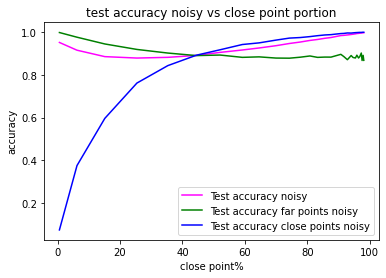

In [24]:
plt.plot(close_portion, 
         Test_accuracy_noisey, 
         label = 'Test accuracy noisy', 
         color = 'magenta')

plt.plot(close_portion, 
         Test_accuracy_far_points_noisy, 
         label = 'Test accuracy far points noisy', 
         color = 'green')

plt.plot(close_portion, 
         Test_accuracy_close_points_noisey, 
         label = 'Test accuracy close points noisy', 
         color = 'blue')

plt.legend()
plt.xlabel('close point%', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.title('test accuracy noisy vs close point portion', fontsize = 12)
plt.savefig('Images/Test_accuracy_noisy_vs_close_point_portion')
plt.show()

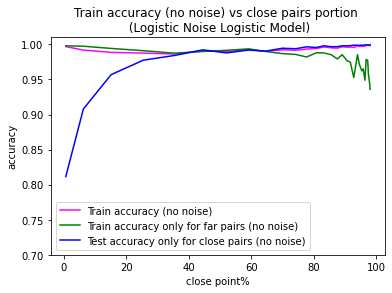

In [32]:
plt.plot(close_portion, 
         Train_accuracy_no_noisey, 
         label = 'Train accuracy (no noise)', 
         color = 'magenta')

plt.plot(close_portion, 
         Train_accuracy_far_points_no_noisy, 
         label = 'Train accuracy only for far pairs (no noise)', 
         color = 'green')

plt.plot(close_portion, 
         Train_accuracy_close_points_no_noisey, 
         label = 'Test accuracy only for close pairs (no noise)', 
         color = 'blue')

plt.legend()
plt.xlabel('close point%', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.ylim((0.7,1.01))
plt.title('Train accuracy (no noise) vs close pairs portion \n (Logistic Noise Logistic Model)', fontsize = 12)
plt.savefig('Images/Train_accuracy_no_noisy_vs_close_point_portion')
plt.show()

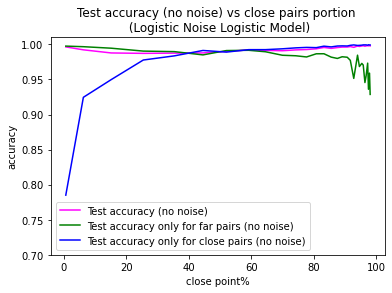

In [47]:
plt.plot(close_portion, 
         Test_accuracy_no_noisey, 
         label = 'Test accuracy (no noise)', 
         color = 'magenta')

plt.plot(close_portion, 
         Test_accuracy_far_points_no_noisy, 
         label = 'Test accuracy only for far pairs (no noise)', 
         color = 'green')

plt.plot(close_portion, 
         Test_accuracy_close_points_no_noisey, 
         label = 'Test accuracy only for close pairs (no noise)', 
         color = 'blue')

plt.legend()
plt.xlabel('close point%', fontsize = 10)
plt.ylabel('accuracy', fontsize = 10)
plt.ylim((0.7, 1.01))
plt.title('Test accuracy (no noise) vs close pairs portion \n (Logistic Noise Logistic Model)', fontsize = 12)
plt.savefig('Images/Test_accuracy_no_noisy_vs_close_point_portion')
plt.show()